In [1]:
import numpy as np
import geopy as gp
import pandas as pd
from geopy.geocoders import Nominatim
from pathlib import Path
from tqdm import tqdm
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, MODELS_DIR

2025-01-05 11:34:53.991 | INFO     | src.config:<module>:13 - PROJ_ROOT path is: G:\Work\DS\where-am-i


In [2]:
df_val = pd.read_csv(INTERIM_DATA_DIR / 'val.csv').drop(columns=['Unnamed: 0'])
#df_val = df_val.loc[df_val['id'] == 1000394234038243]

In [3]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import os
import pandas as pd
from torchvision.io import decode_image, read_file
from torch.utils.data import Dataset
import torch
from pathlib import Path
import time
import torch
import torch.nn as nn
import torch.nn.functional as func
from torchvision import datasets, transforms
#from src.base.OSVImageDataset import OSVImageDataset
from torch.utils.data import DataLoader
from transformers import ViTImageProcessor
from torchvision.transforms import v2

class OSVImageDataset(Dataset):
    def __init__(self, annotations_df, img_dir, transform=None):
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + '.jpg')
        a = time.perf_counter()
        image = decode_image(img_path).float()
        b = time.perf_counter()
        label = torch.tensor([self.img_labels.iloc[idx, 1], self.img_labels.iloc[idx, 2]])
        if self.transform:
            image = self.transform(image)
        #image = image.clamp(0, 1)
        return image, label

c:\Users\Harshavardhan Patil\.virtualenvs\where-am-i-s7vJJwrF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BATCH_SIZE = 64
KERNEL_SIZE = 16 #16x16 patch
CHANNELS = 3 #rgb
RESIZE = 224
EMBED_DIM = CHANNELS * KERNEL_SIZE ** 2
NUM_PATCHES = ((RESIZE + 0 - KERNEL_SIZE)//KERNEL_SIZE + 1) ** 2
MODEL_NAME = "google/vit-base-patch16-224-in21k"

#Using values the ViT was trained on
processor = ViTImageProcessor.from_pretrained(MODEL_NAME, do_rescale = False, return_tensors = 'pt')

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = v2.Normalize(mean=image_mean, std=image_std)

test_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.Normalize(
        mean=[0.0, 0.0, 0.0],  
        std=[255.0, 255.0, 255.0]
    ),
    v2.Normalize(
           mean=[0.5, 0.5, 0.5],
           std=[0.5, 0.5, 0.5]
    #v2.Normalize(
    #       mean=[0.485, 0.456, 0.406],
    #       std=[0.229, 0.224, 0.225]
    )
])

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
print(f"Using device: {device}")


val_dataset = OSVImageDataset(annotations_df = df_val.loc[:, ['id', 'latitude', 'longitude']], img_dir = INTERIM_DATA_DIR / 'val', transform=test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using device: cuda


In [6]:
from geopy import distance
import gc
import time
from src.base.GeoLocator import GeoLocator
from src.base.EmbeddingToGPSDecoder import EmbeddingToGPSDecoder

#model_names = ['1', '2', '4', '6', '9', '12', '15']
model_names = [62]
actuals = []
preds = []
for v in model_names:
    model = GeoLocator().to(device=device)
    model.load_state_dict(torch.load(MODELS_DIR / f'geonn/geonn_v{v}.pt', map_location=device, weights_only=True)['model_state_dict'])
    gps_decoder = EmbeddingToGPSDecoder().to(device=device)
    gps_decoder.load_state_dict(torch.load(MODELS_DIR / "reverse/reversenn.pt", weights_only=True))

    model.eval()
    gps_decoder.eval()
    start = time.perf_counter()
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device=device)
            for label in labels:
                actuals.append(label.cpu().numpy())
            embeds = model(images)
            outputs = gps_decoder(embeds)
            for output in outputs:
                preds.append(output.cpu().numpy())
            
            del images, labels
            gc.collect
            torch.cuda.empty_cache()
    end = time.perf_counter()
    geo_error = []

    for i in zip(actuals, preds):
        geo_error.append(distance.distance(i[0], i[1]).km)
    print(f'perf :{end- start}')
    print(f'Model v{v} val error: {np.mean(geo_error)}')

100%|██████████| 108/108 [01:56<00:00,  1.08s/it]


perf :116.47598670000025
Model v62 val error: 742.6531097168147


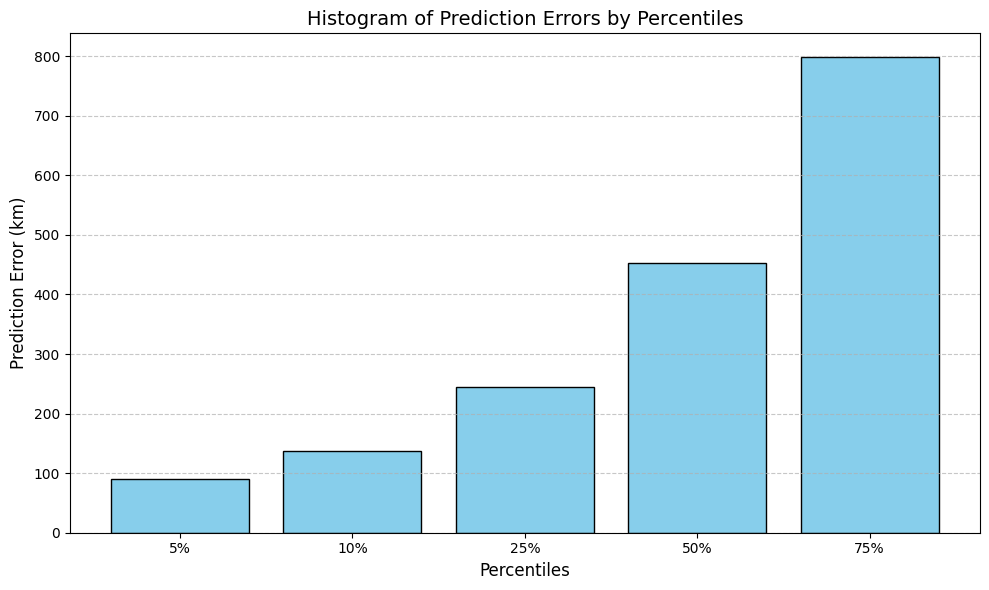

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the percentiles
percentiles = [5, 10, 25, 50, 75]
percentile_values = np.percentile(geo_error, percentiles)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(
    x=[f'{p}%' for p in percentiles], 
    height=percentile_values, 
    color='skyblue', 
    edgecolor='black'
)

# Add labels and title
plt.xlabel('Percentiles', fontsize=12)
plt.ylabel('Prediction Error (km)', fontsize=12)
plt.title('Histogram of Prediction Errors by Percentiles', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
df_val

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,region,sub-region,city,unique_city,unique_sub-region,unique_region,unique_country,quadtree_10_1000,creator_username,creator_id
0,1000394234038243,39.754328,-95.527158,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,fp21i4dth4ogfhpopyup47,1536280416448,22,70,"(22, 70)",...,Kansas,Brown County,Horton,Horton_Brown County_Kansas_US,Brown County_Kansas_US,Kansas_US,US,3012,lvl5,1.044090e+14
1,1000829273784797,33.426979,-105.306405,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,Pbi_He9-CZtu7XEYK7JUYg,1523706752000,19,65,"(19, 65)",...,New Mexico,Lincoln County,Capitan,Capitan_Lincoln County_New Mexico_US,Lincoln County_New Mexico_US,New Mexico_US,US,2400,fta,1.004782e+14
2,1002048857257580,34.434785,-87.194925,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ky4okhbewjuklvcb9cp1ww,1507988501442,24,66,"(24, 66)",...,Alabama,Lawrence County,Moulton,Moulton_Lawrence County_Alabama_US,Lawrence County_Alabama_US,Alabama_US,US,3580,lvl5,1.044090e+14
3,1002141733995175,44.529028,-106.803420,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,4_yzrupEWCxRjfDVmYlYlw_v00,1469831184388,19,73,"(19, 73)",...,Wyoming,Johnson County,Buffalo,Buffalo_Johnson County_Wyoming_US,Johnson County_Wyoming_US,Wyoming_US,US,3075,bundlegut,1.099899e+14
4,1002416657234615,41.263080,-96.113223,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,mGdL5DxyN71kOpSQgbKl4A,1433003411938,22,71,"(22, 71)",...,Nebraska,Sarpy County,Chalco,Chalco_Sarpy County_Nebraska_US,Sarpy County_Nebraska_US,Nebraska_US,US,3080,midnightcomm,1.040009e+14
5,1003756846823167,42.885204,-106.450260,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,aKq9aA78tNUa5bxl7Fpqrg,1558815408000,19,72,"(19, 72)",...,Wyoming,Natrona County,Mills,Mills_Natrona County_Wyoming_US,Natrona County_Wyoming_US,Wyoming_US,US,3067,happymapper,1.002428e+14
6,1004450253715722,36.735896,-111.582126,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,NxDPm6VXfOPxyPixM4c-ng,1442421338876,18,67,"(18, 67)",...,Arizona,Coconino County,LeChee,LeChee_Coconino County_Arizona_US,Coconino County_Arizona_US,Arizona_US,US,2262,canadarunner,1.113204e+14
7,1005610426640187,33.127818,-83.829993,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,mpk_bybHThA5-YhjQmbGQA,1516900566315,25,65,"(25, 65)",...,Georgia,Monroe County,Forsyth,Forsyth_Monroe County_Georgia_US,Monroe County_Georgia_US,Georgia_US,US,3558,mapillary01730,1.005158e+14
8,1006174249916477,41.138604,-101.166722,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,hwlh3x59atukc4sdkcp7yg,1500653068000,21,71,"(21, 71)",...,Nebraska,Lincoln County,Sutherland,Sutherland_Lincoln County_Nebraska_US,Lincoln County_Nebraska_US,Nebraska_US,US,3068,toebee,1.096903e+14
9,1007072136494043,38.414964,-90.487579,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,9cwzlavrawzw2gnthiodo2,1533047740194,24,69,"(24, 69)",...,Missouri,Jefferson County,High Ridge,High Ridge_Jefferson County_Missouri_US,Jefferson County_Missouri_US,Missouri_US,US,2980,4ensic,1.075019e+14


In [30]:

from geopy.geocoders import Nominatim
# initialize Nominatim API 
geolocator = Nominatim(user_agent="GetLoc")
print(geolocator.reverse(preds[0]).raw['address'])
#for i, pred in enumerate(preds):
#    print(f"{geolocator.reverse(actuals[i]).raw['address']['state']}  -  {geolocator.reverse(pred).raw['address']['state']}")

{'road': 'Smart Road', 'city': "Lee's Summit", 'county': 'Jackson County', 'state': 'Missouri', 'ISO3166-2-lvl4': 'US-MO', 'postcode': '64086', 'country': 'United States', 'country_code': 'us'}


### Base Val error
Model v1 val error: 1285.3414956726374

Model v2 val error: 1255.778000665227

Model v4 val error: 1228.4388765900744

Model v6 val error: 1198.3797536049092

Model v7 val error: 1197.4639204861048

Model v8 val error: 1197.9011891280672

Model v9 val error: 1198.277137427626

Model v12 val error: 915.5077883320992

Model v15 val error: 878.3326644097162 - with good spatial difference

Model v16 val error: 869.6155711376241

Model v20 val error: 848.2478268798081

Model v25 val error: 826.7051247257457

Model v28 val error: 834.3187897751632

Model v33 val error: 804.1214841686523

Model v47 val error: 767.6579945673744

Model v59 val error: 744.9732500862989

Model v62 val error: 742.6531097168147

## Swin Base Val Error
Model v3 val error: 1118.031006206268

## Swin Large Val Error

Model v4 val error: 1090.651382981071

Model v5 val error: 1083.0932545596388

Model v6 val error: 1080.2051907171428

had an issue with issue with the preprocessing before this

Model v7 val error: 949.2627891580796

Model v8 val error: 942.0195622179014

Model v9 val error: 960.2753933954593

Model v10 val error: 952.8145841541582

Model v11 val error: 945.8225043306127

Model v12 val error: 939.5201626855373

##  Geodesic distance loss
Model v0 val error: 1526.6536232117917

Model v1 val error: 1526.2698203411826

## MSE Loss
Model v2 val error: 1525.61371584446

Model v3 val error: 1518.1040607737962

Model v4 val error: 1479.7120268209758

Model v5 val error: 1528.7433368154755

In [ ]:
import numpy as np
import gc

model = GeoLocator().to(device=device)
model.load_state_dict(torch.load(MODELS_DIR / f'geonn/geonn_v7.pt', map_location=device, weights_only=True)['model_state_dict'])
gps_decoder = EmbeddingToGPSDecoder().to(device=device)
gps_decoder.load_state_dict(torch.load(MODELS_DIR / "reverse/reversenn.pt", weights_only=True))

model.eval()
gps_decoder.eval()
actuals = []
preds = []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images = images.to(device=device)
        for label in labels:
            actuals.append(label.cpu().numpy())
        embeds = model(images)
        outputs = gps_decoder(embeds)
        for output in outputs:
            preds.append(output.cpu().numpy())
        
        del images, labels
        gc.collect
        torch.cuda.empty_cache()



In [24]:
from geopy.geocoders import Nominatim
# initialize Nominatim API 
geolocator = Nominatim(user_agent="GetLoc")
geolocator.reverse(preds[16]).raw['address']

{'road': 'US Highway 281',
 'village': 'Doniphan',
 'county': 'Hall County',
 'state': 'Nebraska',
 'ISO3166-2-lvl4': 'US-NE',
 'postcode': '68801',
 'country': 'United States',
 'country_code': 'us'}

In [16]:
from transformers import  SwinModel

model = SwinModel.from_pretrained("microsoft/swin-large-patch4-window7-224-in22k").to(device=device)


In [17]:
for images, _ in val_dataloader:
    print(np.shape(model(images.to(device=device)).last_hidden_state))
    break

torch.Size([5, 49, 1536])


In [20]:
from transformers import  SwinModel, AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("microsoft/swin-large-patch4-window7-224-in22k")

In [21]:
processor.to_json_file

<bound method ImageProcessingMixin.to_json_file of ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}
>

In [10]:
((1.2e6 / 32985) * 19) / 60

11.520388055176594